# Medical Diagnosis using Chest X-Ray - (Keras Version)


## Introduction

TODO

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sns.set()
%matplotlib inline 

In [2]:
train_df = pd.read_csv('../data/chest_x_ray/train-small.csv')
print(f'training dataset size: {len(train_df)}')

train_df.head(5)

training dataset size: 875


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027079_001.png,0,0,0,0,0,0,0,0,0,0,0,27079,1,0,0
1,00004477_001.png,1,0,0,0,1,0,0,0,0,0,0,4477,0,0,0
2,00018530_002.png,0,0,0,0,0,0,0,0,0,0,0,18530,0,0,0
3,00026928_001.png,0,0,0,0,0,0,0,0,1,0,0,26928,0,0,0
4,00016687_000.png,0,0,0,0,0,0,0,0,0,0,1,16687,0,0,0


In [3]:
valid_df = pd.read_csv('../data/chest_x_ray/valid-small.csv')
print(f'validation dataset size: {len(valid_df)}')

valid_df.head(5)

validation dataset size: 109


,Image,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,PatientId,Pleural_Thickening,Pneumonia,Pneumothorax
0,00027623_007.png,0,0,0,1,1,0,0,0,0,0,0,27623,0,0,0
1,00028214_000.png,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0
2,00022764_014.png,0,0,0,0,0,0,0,0,0,0,0,22764,0,0,0
3,00020649_001.png,1,0,0,0,1,0,0,0,0,0,0,20649,0,0,0
4,00022283_023.png,0,0,0,0,0,0,0,0,0,0,0,22283,0,0,0


In [4]:
test_df = pd.read_csv('../data/chest_x_ray/test-small.csv')
print(f'test dataset size: {len(test_df)}')

test_df.head(5)

test dataset size: 420


,Image,PatientId,Cardiomegaly,Emphysema,Effusion,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00021463_005.png,21463,0,0,1,1,1,0,0,1,0,0,0,0,1,0
1,00019733_002.png,19733,0,0,0,1,0,0,0,1,0,0,0,0,0,0
2,00021463_001.png,21463,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,00017136_020.png,17136,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,00027477_000.png,27477,0,0,0,1,1,0,0,0,0,0,0,0,0,0


In [5]:
labels = ['Cardiomegaly', 
          'Emphysema', 
          'Effusion', 
          'Hernia', 
          'Infiltration', 
          'Mass', 
          'Nodule', 
          'Atelectasis',
          'Pneumothorax',
          'Pleural_Thickening', 
          'Pneumonia', 
          'Fibrosis', 
          'Edema', 
          'Consolidation']

## Preventing Data Leakage

TODO: write-up

In [6]:
def check_for_leakage(df1, df2, patient_col):
    
    df1_unique = set(df1[patient_col].unique())
    df2_unique = set(df2[patient_col].unique())
    
    patients_in_both = df1_unique.intersection(df2_unique)
    return len(patients_in_both) > 0

In [7]:
print(f"leakage between train and test: {check_for_leakage(train_df, test_df, 'PatientId')}")
print(f"leakage between valid and test: {check_for_leakage(valid_df, test_df, 'PatientId')}")

leakage between train and test: False
leakage between valid and test: False


## Image Preprocessing 

TODO: write-up

### Preprocess Training Dataset 

In [8]:
def get_train_generator(df, image_dir, x_col, y_cols, 
                         shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    print("getting train and valid generators...")
    image_generator = ImageDataGenerator(samplewise_center=True,
                                        samplewise_std_normalization=True)
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    return generator

### Preprocess Validation and Testing Datasets

In [9]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, 
                                   sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: 
        iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="Image", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [10]:
IMAGE_DIR = "../data/chest_x_ray/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "Image", labels)
valid_generator, test_generator= get_test_and_valid_generator(valid_df, test_df, train_df, IMAGE_DIR, "Image", labels)

getting train and valid generators...
Found 9 validated image filenames.
getting train and valid generators...
Found 9 validated image filenames.


/Users/upul/Experiments/Artificial-Intelligence-for-Medicine/venv/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 866 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Found 1 validated image filenames.
Found 412 validated image filenames.


/Users/upul/Experiments/Artificial-Intelligence-for-Medicine/venv/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 108 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/Users/upul/Experiments/Artificial-Intelligence-for-Medicine/venv/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 8 invalid image filename(s) in x_col="Image". These filename(s) will be ignored.
  .format(n_invalid, x_col)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


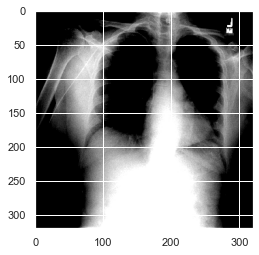

In [11]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0])
plt.show()

## Model Development

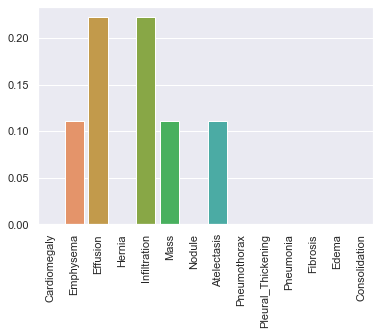

In [12]:
bar_polt = sns.barplot(labels, np.mean(train_generator.labels, axis=0))
for item in bar_polt.get_xticklabels():
    item.set_rotation(90)

### How to Mitigate the Class Imbalance Problem?

#### Weighted Loss Function

TODO: write-up

In [13]:
def calculate_class_frequencies(labels):
    """
    """
    pos_freq, neg_freq = np.mean(labels == 1, axis=0), np.mean(labels == 0, axis=0)
    return pos_freq, neg_freq

In [14]:
test_labels = np.array([[0, 1, 0, 0],
                       [1, 0, 0, 0],
                       [1, 0, 0, 1],
                       [0, 0, 1, 1]])
pos, neg = calculate_class_frequencies(test_labels)

assert np.all(pos - np.array([0.5 , 0.25, 0.25, 0.5 ])) < 1e-10
assert np.all(neg - np.array([0.5 , 0.75, 0.75, 0.5 ])) < 1e-10

In [15]:
test_labels = np.array(
    [[1, 0, 0],
     [0, 1, 1],
     [1, 0, 1],
     [1, 1, 1],
     [1, 0, 1]]
)
pos, neg = calculate_class_frequencies(test_labels)

assert np.all(pos - np.array([0.8, 0.4, 0.8])) < 1e-10
assert np.all(neg - np.array([0.2, 0.6, 0.2])) < 1e-10

OK, now we calculate the negative and positive frequencies of each pathology. Also, let's visualize these frequencies using a bar graph. 

In [16]:
pos_training, neg_training = \
    calculate_class_frequencies(train_generator.labels)

assert len(pos_training) == len(labels)
assert len(neg_training) == len(labels)

In [17]:
neg_training

array([1.        , 0.88888889, 0.77777778, 1.        , 0.77777778,
       0.88888889, 1.        , 0.88888889, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        ])

In [18]:
pos_training

array([0.        , 0.11111111, 0.22222222, 0.        , 0.22222222,
       0.11111111, 0.        , 0.11111111, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [46]:
data = pd.DataFrame({'class': labels, 'label': 'negative', 'value': neg_training})
data = data.append([{'class': labels[i], 'label': 'positive', 'value': pos_training[i]}
            for i in range(len(pos_training))], ignore_index=True)

assert len(data) == len(pos_training) + len(neg_training)

In [52]:
data[0:5]

,class,label,value
0,Cardiomegaly,negative,1.000000
1,Emphysema,negative,0.888889
2,Effusion,negative,0.777778
3,Hernia,negative,1.000000
4,Infiltration,negative,0.777778


In [53]:
data[14:19]

,class,label,value
14,Cardiomegaly,positive,0.000000
15,Emphysema,positive,0.111111
16,Effusion,positive,0.222222
17,Hernia,positive,0.000000
18,Infiltration,positive,0.222222


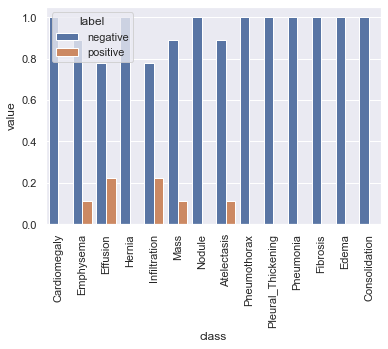

In [70]:
plt.xticks(rotation=90)
bar_graph = sns.barplot(x='class', y='value', hue='label', data=data)
plt.show()